# Creacion de nuevas variables

El objetivo principal es derivar variables de las serie de consumo mensual. 

**Ejemplo :** 

    1. min, maximo, pendientes.
    2. variables estadisticas,temporaales y expectrales.
    
**Paquete :**

- [TSFEL](https://tsfel.readthedocs.io/en/latest/)
- [Ejemplo de uso](https://github.com/fraunhoferportugal/tsfel/blob/master/notebooks/TSFEL_SMARTWATCH_HAR_Example.ipynb)
- Otro paquete --> [TSFRESH](https://tsfresh.readthedocs.io/en/latest/)

In [1]:
import os
import sys
import pandas as pd
import warnings
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib import pyplot as plt
import tsfel
from itertools import groupby

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) #evita mostrar notacion cientifica

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
def llenar_val_vacios_ciclo(df, cant_ciclos_validos):
    cols_consumo = [f'{i}_anterior' for i in range(cant_ciclos_validos, 0, -1)]
    print(cols_consumo)
    df.loc[:, cols_consumo] = df.loc[:, cols_consumo].fillna(method='ffill', axis=1)
    df.loc[:, cols_consumo] = df.loc[:, cols_consumo].fillna(method='bfill', axis=1)
    return df


class TsfelVars(BaseEstimator, TransformerMixin):

    def __init__(self, features_names_path=None, num_periodos=12):
        self.num_periodos = num_periodos
        self.features_names_path = features_names_path

    def obtener_cols_anterior(self, num_cols=12):
        return [f'{i}_anterior' for i in range(num_cols,0, -1)]

    def extra_cols(self, df, domain, cols, window=12):
        cfg = tsfel.get_features_by_domain(domain)
        df_result = tsfel.time_series_features_extractor(cfg, df[cols].values,n_jobs=-1)
        df_result['index'] = df.index
        print('df_result index:',df_result['index'].shape)
        return df_result
    
    def compute_by_json(self,df, cols, window=12):
        cfg = tsfel.get_features_by_domain(json_path=self.features_names_path)
        df_result = tsfel.time_series_features_extractor(cfg, df[cols].values,n_jobs=-1)
        df_result['index'] = df.index
        print('df_result index:',df_result['index'].shape)
        return df_result

    def crear_all_tsfel(self, df):
        print('ENTRI a CREAR TSFEL')
        cols_anterior = self.obtener_cols_anterior(self.num_periodos)
        df_result_stat = self.extra_cols(df, "statistical", cols_anterior, window=self.num_periodos)
        df_result_temporal = self.extra_cols(df, "temporal", cols_anterior, window=self.num_periodos)
        df_result_spectral = self.extra_cols(df, "spectral", cols_anterior, window=self.num_periodos)
        self.temp_vars = df_result_temporal.columns.tolist()
        self.temp_vars.remove('index')
        self.stat_vars = df_result_stat.columns.tolist()
        self.stat_vars.remove('index')
        self.spec_vars = df_result_spectral.columns.tolist()
        self.spec_vars.remove('index')
        print('temp_vars', len(self.temp_vars))
        print('stat_vars', len(self.stat_vars))
        print('spec_vars', len(self.spec_vars))
        return df_result_stat, df_result_temporal, df_result_spectral

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.features_names_path != None:
            print("ENTRO PARA CREAR JSON")
            cols_anterior = self.obtener_cols_anterior(self.num_periodos)
            df_tsfel = self.compute_by_json(X, cols_anterior, window=self.num_periodos)
            print('df_tsfel', df_tsfel.shape)
            X = X.merge(df_tsfel, on='index', how='left')
            
        else:
            print("ENTRO PARA CREAR")
            df_result_stat, df_result_temporal, df_result_spectral = self.crear_all_tsfel(X)
            df_tsfel = pd.merge(df_result_stat, df_result_temporal, how='inner', on='index')
            df_tsfel = pd.merge(df_tsfel, df_result_spectral, how='inner', on='index')
            print('df_tsfel', df_tsfel.shape)
            X = X.merge(df_tsfel, on='index', how='left')

        return X
    
class ExtraVars(BaseEstimator, TransformerMixin):
    def __init__(self,num_periodos=3):
        self.num_periodos = num_periodos
    
    def fit(self, X, y=None):
        return self

    def obtener_cols_anterior(self, num_cols=12):
        return [f'{i}_anterior' for i in range(num_cols, 0, -1)]

    def transform(self, X):
        return self.create_vbles(X)

    def count_cero(self, x):
        return (x == 0.0).sum()

    def count_cero_seguidos(self, x):
        ceros_seguidos = 2
        consumo = x.values
        g = [[k, len(list(v))] for k, v in groupby(consumo)]
        g = [x for x in g if (x[0] == 0.0) & (x[1] >= ceros_seguidos)]
        if any(g):
            return sorted(g, reverse=True, key=lambda x: x[-1])[0][1]
        else:
            return 0

    def calc_slope(self, x):
        consumo = list(x.values)
        slope = np.polyfit(range(len(consumo)), consumo, 1)[0]
        return slope

    def create_vbles(self, df_total_super):
        # generar listado de cols de atras hacia delante i.e: ['3_anterior', '2_anterior', '1_anterior'], etc.
        cols_3_anterior = self.obtener_cols_anterior(num_cols=self.num_periodos)
        num_periodos_str = str(self.num_periodos)
        ## promedios
        df_total_super.loc[:, 'mean_' + num_periodos_str] = df_total_super[cols_3_anterior].mean(axis=1)
        ## Cantidad de ceros
        df_total_super.loc[:, 'cant_ceros_' + num_periodos_str] = df_total_super[cols_3_anterior].apply(self.count_cero,
                                                                                                        axis=1)
        df_total_super.loc[:, 'max_cant_ceros_seg_' + num_periodos_str] = df_total_super[cols_3_anterior].apply(
            self.count_cero_seguidos, axis=1)
        ## Slope
        df_total_super.loc[:, 'slope_' + num_periodos_str] = df_total_super[cols_3_anterior].apply(self.calc_slope,
                                                                                                   axis=1)
        ## Min, Max, STD, Varianza 3 periodos
        df_total_super.loc[:, 'min_cons' + num_periodos_str] = df_total_super[cols_3_anterior].min(axis=1)
        df_total_super.loc[:, 'max_cons' + num_periodos_str] = df_total_super[cols_3_anterior].max(axis=1)
        df_total_super.loc[:, 'std_cons' + num_periodos_str] = df_total_super[cols_3_anterior].std(axis=1)
        df_total_super.loc[:, 'var_cons' + num_periodos_str] = df_total_super[cols_3_anterior].var(axis=1)
        ## skewness y kurtosis 3 periodos
        df_total_super.loc[:, 'skew_cons' + num_periodos_str] = df_total_super[cols_3_anterior].skew(axis=1)
        if self.num_periodos > 3:
            df_total_super.loc[:, 'kurt_cons' + num_periodos_str] = df_total_super[cols_3_anterior].kurt(axis=1)

        return df_total_super

## Ejemplo

In [6]:
serie_consumo_anteriores = [153.0,  125.0,  117.0,  120.0,  128.0,  80.0,  105.0,  123.0,  101.0,  111.0,  99.0,  96.0]

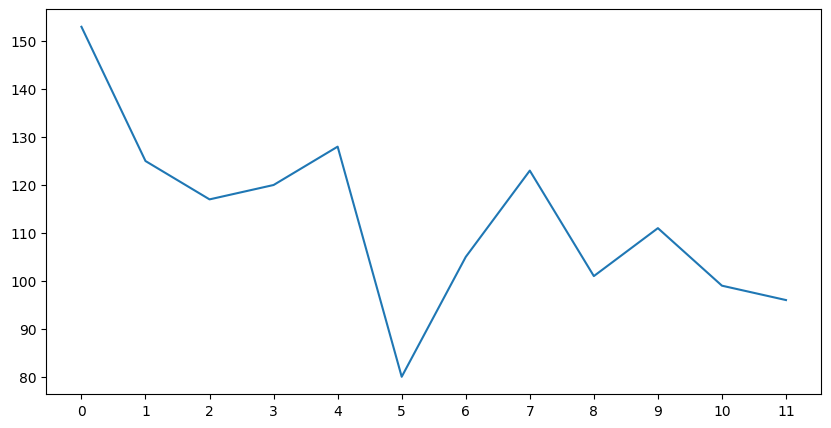

In [7]:
plt.figure(figsize=(10,5))
plt.plot(serie_consumo_anteriores)
plt.xticks(range(12));

In [8]:
cfg = tsfel.get_features_by_domain("statistical")
df_result = tsfel.time_series_features_extractor(cfg, serie_consumo_anteriores,n_jobs=-1)

*** Feature extraction started ***
16


In [9]:
df_result

0_ECDF_0  0_ECDF_1  0_ECDF_2  0_ECDF_3  0_ECDF_4  0_ECDF_5  0_ECDF_6  \
0      0.08      0.17      0.25      0.33      0.42      0.50      0.58   

   0_ECDF_7  0_ECDF_8  0_ECDF_9  0_ECDF Percentile_0  0_ECDF Percentile_1  \
0      0.67      0.75      0.83                96.00               123.00   

   0_ECDF Percentile Count_0  0_ECDF Percentile Count_1  0_Histogram_0  \
0                       2.00                       9.00           0.00   

   0_Histogram_1  0_Histogram_2  0_Histogram_3  0_Histogram_4  0_Histogram_5  \
0           0.00           0.00           0.00           0.00           0.00   

   0_Histogram_6  0_Histogram_7  0_Histogram_8  0_Histogram_9  \
0           0.00           0.00           0.00           0.00   

   0_Interquartile range  0_Kurtosis  0_Max  0_Mean  \
0                  23.00        0.09 153.00  113.17   

   0_Mean absolute deviation  0_Median  0_Median absolute deviation  0_Min  \
0                      14.50    114.00                        12.00  80.00   

   0_Root mean square  0_Skewness  0_Standard deviation  0_Variance  
0              114.60        0.32                 18.07      326.64

## Levantamos dataSets

In [10]:
filename = '../../data/clean_data/eegsa_wide_train_data.parquet'
df = pd.read_parquet(filename)
df.shape

(30932, 37)

In [11]:
df.rename(columns={'id_usuario':'uc'}, inplace=True)
df.rename(columns={'id':'index'}, inplace=True)

In [12]:
cant_ciclos = 12
df = llenar_val_vacios_ciclo(df, cant_ciclos) 

['12_anterior', '11_anterior', '10_anterior', '9_anterior', '8_anterior', '7_anterior', '6_anterior', '5_anterior', '4_anterior', '3_anterior', '2_anterior', '1_anterior']


In [13]:
# cols = ['uc', 'index'] + [f'{i}_anterior' for i in range(cant_ciclos, 0, -1)]
# df = df[cols]

In [16]:
df.shape

(30932, 37)

In [17]:
df.head()

uc  12_anterior  11_anterior  10_anterior  9_anterior  8_anterior  \
0   100035       153.00       125.00       117.00      120.00      128.00   
1   100043       253.00       246.00       259.00      262.00      254.00   
2    10008       187.00         0.00       205.00      187.00      178.00   
3  1000912       657.00       576.00       636.00      595.00      659.00   
4  1000996        70.00        61.00        61.00       69.00       85.00   

   7_anterior  6_anterior  5_anterior  4_anterior  3_anterior  2_anterior  \
0       80.00      105.00      123.00      101.00      111.00       99.00   
1      184.00      188.00      189.00      201.00      204.00      189.00   
2      194.00      200.00      188.00      168.00        0.00        0.00   
3      598.00      616.00      657.00      613.00      613.00      633.00   
4       97.00       96.00       95.00      100.00      104.00       90.00   

   1_anterior date_fizcalizacion  cant_ttarifa departamento  \
0       96.00         2022-01-01             1    guatemala   
1      188.00         2022-01-01             1    guatemala   
2       26.00         2022-01-01             1    guatemala   
3      616.00         2022-01-01             1    guatemala   
4       76.00         2022-01-01             1    guatemala   

            municipio     zona tipo_tarifa contrato       date  cod_mat  \
0         villa_nueva   zona_3          TS   100035 2022-01-01  41-0069   
1           guatemala   zona_4          TS   100043 2022-01-01  41-0081   
2           guatemala  zona_10          TS    10008 2022-01-01  41-0083   
3               mixco   zona_4         TNS  1000912 2022-01-01  41-0083   
4  san_jose_del_golfo   zona_0          TS  1000996 2022-01-01  41-0084   

   is_fraud  cant_null  eliminar unidad_de_lectura codigo_postal  \
0         0          0         0           708-008          1064   
1         0          0         0           605-015          1004   
2         0          0         0           603-001          1010   
3         0          0         0           612-039          1057   
4         0          0         0           813-035          1053   

  fecha_de_alta no_de_poste tarfia  multiplicador actividad_economica  \
0    2001-07-11      238366    R11           1.00              83_009   
1    2001-07-06      135771    C11           1.00              85_009   
2    2001-07-04      107349    C11           1.00              83_002   
3    2008-07-24      518933    C11           1.00              49_005   
4    2008-07-24      386109    R11           1.00              83_009   

   kw_cont medidor_interior          folio  nivel_de_tension  index  
0     0.00         sin_dato  708-10329-000              2.00      0  
1     0.00         sin_dato  605-11884-000              2.00      1  
2     0.00                X  603-02018-000              2.00      2  
3     0.00         sin_dato  612-53632-000              2.00      3  
4     0.00         sin_dato  813-61192-000              2.00      4

In [18]:
%%time
pipe_feature_eng_train = Pipeline(
    [
        ("tsfel vars", TsfelVars(features_names_path=None, num_periodos= cant_ciclos)),
        ("add vars3", ExtraVars(num_periodos=3)),
        ("add vars6", ExtraVars(num_periodos=6)),
        ("add vars12", ExtraVars(num_periodos=12)),

    ]
)
tsfel_extra_var = pipe_feature_eng_train.fit_transform(df, None)

ENTRO PARA CREAR
ENTRI a CREAR TSFEL
*** Feature extraction started ***



*** Feature extraction finished ***
df_result index: (30932,)
*** Feature extraction started ***



*** Feature extraction finished ***
df_result index: (30932,)
*** Feature extraction started ***



*** Feature extraction finished ***
df_result index: (30932,)
temp_vars 18
stat_vars 36
spec_vars 87
df_tsfel (30932, 142)
CPU times: user 7min 39s, sys: 1min 52s, total: 9min 32s
Wall time: 12min 59s


In [36]:
tsfel_extra_var.shape

(30932, 207)

In [37]:
tsfel_extra_var.to_parquet('tmp/df_tsfel_variables.parquet')

In [38]:
tsfel_extra_var.head()

uc  12_anterior  11_anterior  10_anterior  9_anterior  8_anterior  \
0   100035       153.00       125.00       117.00      120.00      128.00   
1   100043       253.00       246.00       259.00      262.00      254.00   
2    10008       187.00         0.00       205.00      187.00      178.00   
3  1000912       657.00       576.00       636.00      595.00      659.00   
4  1000996        70.00        61.00        61.00       69.00       85.00   

   7_anterior  6_anterior  5_anterior  4_anterior  3_anterior  2_anterior  \
0       80.00      105.00      123.00      101.00      111.00       99.00   
1      184.00      188.00      189.00      201.00      204.00      189.00   
2      194.00      200.00      188.00      168.00        0.00        0.00   
3      598.00      616.00      657.00      613.00      613.00      633.00   
4       97.00       96.00       95.00      100.00      104.00       90.00   

   1_anterior date_fizcalizacion  cant_ttarifa departamento  \
0       96.00         2022-01-01             1    guatemala   
1      188.00         2022-01-01             1    guatemala   
2       26.00         2022-01-01             1    guatemala   
3      616.00         2022-01-01             1    guatemala   
4       76.00         2022-01-01             1    guatemala   

            municipio     zona tipo_tarifa contrato       date  cod_mat  \
0         villa_nueva   zona_3          TS   100035 2022-01-01  41-0069   
1           guatemala   zona_4          TS   100043 2022-01-01  41-0081   
2           guatemala  zona_10          TS    10008 2022-01-01  41-0083   
3               mixco   zona_4         TNS  1000912 2022-01-01  41-0083   
4  san_jose_del_golfo   zona_0          TS  1000996 2022-01-01  41-0084   

   is_fraud  cant_null  eliminar unidad_de_lectura codigo_postal  \
0         0          0         0           708-008          1064   
1         0          0         0           605-015          1004   
2         0          0         0           603-001          1010   
3         0          0         0           612-039          1057   
4         0          0         0           813-035          1053   

  fecha_de_alta no_de_poste tarfia  multiplicador actividad_economica  \
0    2001-07-11      238366    R11           1.00              83_009   
1    2001-07-06      135771    C11           1.00              85_009   
2    2001-07-04      107349    C11           1.00              83_002   
3    2008-07-24      518933    C11           1.00              49_005   
4    2008-07-24      386109    R11           1.00              83_009   

   kw_cont medidor_interior          folio  nivel_de_tension  index  \
0     0.00         sin_dato  708-10329-000              2.00      0   
1     0.00         sin_dato  605-11884-000              2.00      1   
2     0.00                X  603-02018-000              2.00      2   
3     0.00         sin_dato  612-53632-000              2.00      3   
4     0.00         sin_dato  813-61192-000              2.00      4   

   0_ECDF Percentile Count_0  0_ECDF Percentile Count_1  0_ECDF Percentile_0  \
0                       2.00                       9.00                96.00   
1                       2.00                       9.00               188.00   
2                       2.00                       9.00                 0.00   
3                       2.00                       9.00               595.00   
4                       2.00                       9.00                61.00   

   0_ECDF Percentile_1  0_ECDF_0  0_ECDF_1  0_ECDF_2  0_ECDF_3  0_ECDF_4  \
0               123.00      0.08      0.17      0.25      0.33      0.42   
1               253.00      0.08      0.17      0.25      0.33      0.42   
2               188.00      0.08      0.17      0.25      0.33      0.42   
3               636.00      0.08      0.17      0.25      0.33      0.42   
4                96.00      0.08      0.17      0.25      0.33      0.42   

   0_ECDF_5  0_ECDF_6  0_ECDF_7  0_ECDF